In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager
from utils.codificication_mlp import Layer, Cromosome, Fitness        

from time import time

Using TensorFlow backend.


In [2]:
def time_measure(chrom, iters=50):
    '''
    Function tu mesure the training time of a model
    '''
    times = []
    for i in range(iters):
        ti = time()
        c.fitness()
        times.append(time() - ti)
    return times



### Test the capability of a neural network with a single layer

In [5]:
c = Cromosome([Layer(930, 'prelu', 0.654)])


# Fitness params
epochs = 75
batch_size = 256
verbose = 1
redu_plat = False
early_stop = True

# dataset params:
dataset = 'mnist'
classes = []

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=verbose, reduce_plateau=redu_plat, 
                   epochs=epochs, early_stop=early_stop)

(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 930)               730050    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 930)               930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 930)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                9310      
Total params: 740,290
Trainable params: 740,290
Non-trainable params: 0
_________________________________________________________________
Trai

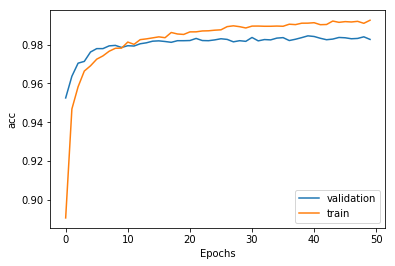

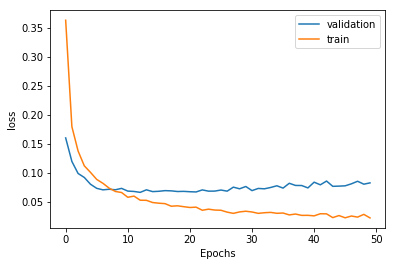

0.9845

In [6]:
c.fitness()

#### training time measurement when resetting VRAM memory

In [3]:
l = Layer(516, 'relu', 0.2)
l2 = Layer(516, 'relu', 0.2)
c = Cromosome([l, l2])

# params:
dataset = 'mnist'
classes = [4, 9]
epochs = 2

# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs)

t_with_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_with_reset), np.std(t_with_reset)))

(9432, 28, 28, 1) train samples
(2359, 28, 28, 1) validation samples
(1991, 28, 28, 1) test samples
mean time:	1.326
std:	1.473


In [4]:
fitness.set_params(data, verbose=0, reduce_plateau=False, epochs=epochs, reset=False)

t_without_reset = time_measure(c)
print("mean time:\t%0.3f\nstd:\t%0.3f" % (np.mean(t_without_reset), np.std(t_without_reset)))

mean time:	2.145
std:	0.610


In [ ]:
from scipy import stats
t_value, p_value = stats.ttest_ind(t_without_reset, t_with_reset)
print("T-value: %0.3f " % t_value)
print("P-value: %0.3f " % p_value)

#### A little class to test the Parent Selector Objects

In [5]:
class A:
    def __init__(self, N_participants=3):
        self.N = N_participants
        self.history_fitness = {}
        
    def set_params(self,maximize, history):
        self.maximize = maximize
        self.history_fitness = history
        
    def eval_individual(self, chrom):
        gen = chrom.__repr__()
        if gen not in self.history_fitness.keys():
            self.history_fitness[gen] = chrom.fitness()
        elif chrom.fit is None:
            chrom.fit = self.history_fitness[gen]
        return chrom.fit
    
    def get_one_offspring(self, population):
        idxs = np.linspace(0, len(population) - 1, len(population)).astype(np.int32)
        idxs_perm = np.random.permutation(idxs)
        participants_1 = [population[idxs_perm[i]] for i in range(self.N)]
        participants_2 = [population[idxs_perm[-i]] for i in range(1, self.N + 1)]
        win_1 = np.argmax([self.eval_individual(chrom) for chrom in participants_1])
        win_2 = np.argmax([self.eval_individual(chrom) for chrom in participants_2])
        parent1 = participants_1[win_1]
        parent2 = participants_2[win_2]
        offspring = parent1.cross(parent2)
        offspring.mutate()
        self.eval_individual(offspring)
        return offspring, (parent1, parent2)
        
    def next_gen(self, population, num_offspring=1):
        next_generation = []
        all_parents = []
        for n in range(num_offspring):
            print(len(population))
            offspring, parents = self.get_one_offspring(population)
            next_generation.append(offspring)
            all_parents.append(parents)
        return next_generation, all_parents
    
class B:
    def __init__(self, n):
        self.n = n
        self.fit = self.n
        
    def __repr__(self):
        return str(self.n)

    def fitness(self):
        return self.n
    
    def cross(self, aB):
        return B(np.mean([self.n, aB.n]))
    
    def mutate(self):
        self.n += np.random.rand()*0
        
a = [0,1,2,3,4,5,6,7,8,9,10]
b = [B(aux) for aux in a]

# Test LinealOrder
a_ = LinealOrder()
next_generation, all_parents = a_.next_gen(b, 10000)

### Optimize a 2D - function with GA

Chromosome to minimize the fuction:

\begin{equation}
f(x) = x \cdot sin(4x) + 1.1  y \cdot sin(2y)
\end{equation}

In [4]:
class chrom:
    def __init__(self, x=0, y=0, mutation_prob=0.2):
        self.x = x
        self.y = y
        self.mut_prob = mutation_prob
        self.fit = None
    
    def set_fitness(self, fit):
        self.evaluator = fit
        
    def random_indiv(self):
        x = 10 * np.random.rand()
        y = 10 * np.random.rand()
        return chrom(x, y)
    
    def simple_indiv(self):
        return chrom(0, 0)
        
    def cross(self, other_cromosome):
        bx = np.random.rand()
        by = np.random.rand()
        x = bx * self.x + (1 - bx) * other_cromosome.x
        y = by * self.y + (1 - by) * other_cromosome.y
        return chrom(x, y)
        
    
    def mutate(self):
        if np.random.rand() < self.mut_prob:
            self.x = 10 * np.random.rand()
        if np.random.rand() < self.mut_prob:
            self.y = 10 * np.random.rand()
            
    def equals(self, other_cromosome):
        return (self.x == other_cromosome.x) and (self.y == other_cromosome.y)
    
    def __repr__(self):
        return "(%0.3f, %0.3f)" % (self.x, self.y)
    
    def fitness(self):
        self.fit = self.x * np.sin(4 * self.x) + 1.1 * self.y * np.sin(2 * self.y)
        return self.fit
    
    def cross_val(self):
        return [self.fitness() for i in range(4)]

In [7]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5

c = chrom(mutation_prob=mut_prob)
ps = [RandomParentSelector(), LinealOrder(), LinealOrderII(), WheelSelection(), TournamentSelection(5)]
p = ps[2]
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

winner, best_fit, ranking = generational.evolve(show=False)
print(best_fit)
print(winner)

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
-18.54115976408368
(9.027, 8.681)


-18.554716504097726 19.861786404025292


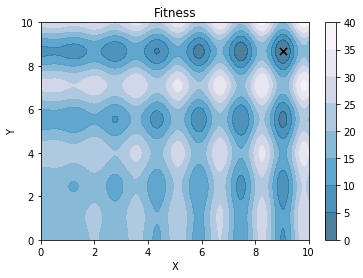

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(0, 10.0, N)
y = np.linspace(0, 10.0, N)

X, Y = np.meshgrid(x, y)
z = X * np.sin(4 * X) + 1.1 * Y * np.sin(2 * Y) 
print(np.min(z), np.max(z))
z += np.abs(np.min(z))
min_z = np.min(z)
max_z = np.max(z)
max_idxs = []
min_idxs = []
for i in range(N):
    for k in range(N):
        if z[i, k] == min_z:
            min_idxs.append((i, k))
        elif z[i, k] == max_z:
            max_idxs.append((i, k))

# The following is not strictly essential, but it will eliminate
# a warning.  Comment it out to see the warning.
#z = ma.masked_where(z <= 0, z)


# Automatic selection of levels works; setting the
# log locator tells contourf to use a log scale:
fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in max_idxs:
    continue
    plt.scatter(x[k], y[i], c='r', label='max', s=20)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=50, marker='x')
# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitness')
ax.set_ylim((np.min(Y), np.max(Y)))
cbar = fig.colorbar(cs)
plt.show()

In [14]:
h = generational.population_history
def scatter_pop(h, generation, ax):
    for p in h[generation]:
        ax.scatter(p.x, p.y, c='g', label='min', s=100)
        
print(len(h), generations)

101 100


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((np.min(X), np.max(X)))
ax.set_ylim((np.min(Y), np.max(Y)))
cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
for i, k in min_idxs:
    plt.scatter(x[k], y[i], c='k', label='min', s=100, marker='x')
ax.set_xlabel('X')
ax.set_ylabel('Y')
title = ax.set_title('')
plt.close(fig)
            
def animate2(i):
    ax.cla()
    ax.set_title('generation %s' % str(i).zfill(4))
    cs = ax.contourf(X, Y, z, cmap=cm.PuBu_r, alpha = 0.7)
    for i_, k_ in min_idxs:
        ax.scatter(x[k_], y[i_], c='k', label='min', s=100, marker='x')
    ax.set_xlim((np.min(X), np.max(X)))
    ax.set_ylim((np.min(Y), np.max(Y)))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    scatter_pop(h, i, ax)
    return

In [ ]:
anim = animation.FuncAnimation(fig,
                               animate2,
                               init_func=None,
                               frames=generations,
                               interval=100000)

# Set up formatting for the movie files
Writer = animation.writers['imagemagick']
writer = Writer(fps=5, metadata=dict(artist='Me'), bitrate=1800)
anim.save('/home/daniel/proyectos/Tesis/project/GA/NeuroEvolution/anim2.gif', writer=writer)

In [21]:
pop_size = 12
mut_prob = 0.2
generations = 100
num_parents = 0.5
iters = 100

c = chrom(mutation_prob=mut_prob)

ps = {'random':RandomParentSelector(), 'linealI':LinealOrder(), 'linealII':LinealOrderII(), 
      'wheel':WheelSelection(), 'tournament5': TournamentSelection(5), 'tournament3': TournamentSelection(3)}

all_fits = {}
for key in ps.keys():
    if key == 'wheel':
        continue
    print("Evaluating " + key + " parent selector")
    p = ps[key]
    all_fits[key] = []
    for i in range(iters):
        generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=pop_size, crossover_prob=0.5,
                              mutation_prob=0.7, maximize_fitness=False, save_pop=True,
                              statistical_validation=False)

        winner, best_fit, ranking = generational.evolve(show=False)
        all_fits[key].append(best_fit)



Evaluating randomparent selector
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algor

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Evaluating tournament3parent selector
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic 

Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generations: 100
Population size: 12
num parents: 6
offspring size: 6
Genetic algorithm params:
Number of generation

In [22]:
for key, value in all_fits.items():
    print(key,"score: %0.4f  +-  %0.4f" % (np.mean(value), np.std(value)))

random score: -25.5032  +-  6.1512
linealI score: -26.0051  +-  5.4390
linealII score: -26.4715  +-  5.4950
tournament5 score: -27.9516  +-  5.6047
tournament3 score: -27.3675  +-  6.1080


### Lineal Order I

\begin{equation}
SelectionProb_i = \frac{Position_i}{\sum_{j}{Position_j}}
\end{equation}

### Lineal Order II

\begin{equation}
SelectionProb_i = \frac{N_{keep} - Position_i + 1}{\sum_{j}^{N_{keep}}{Position_j}}
\end{equation}